# Reproduce  H. Huang , et. al , Faraday Discuss., 2018, 208, 555 – 573 

This notebook demonstrates reproducing the results of the paper with [Larch](https://xraypy.github.io/xraylarch/xafs/) using the corresponding published dataset (raw data). 


Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) **Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study.** Faraday Discussions. V. 208. pp. 555-573. DOI: [10.1039/c7fd00221a](https://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.


For more details about Larch, see [Larch Website](https://xraypy.github.io/xraylarch/xafs/)

## Reproduce Figure 4 - XANES Analysis
The first set of XAS results in the paper are in [Figure 4](https://pubs.rsc.org/image/article/2018/fd/c7fd00221a/c7fd00221a-f4_hi-res.gif)

To reproduce this image we need to:
- A: Identify the XANES data used (SnO2, Air, Ar, H2 and Sn foil)
  - Plot normalised flattened mE of the spectra on the range 29190 – 29450 
  - Plot first derivate of the spectra on the range 29190 – 29215
- B: Take Sn foil and SnO2 and do LCF of the peaks against H2, Ar, and Air
- C: Take Sn K-Edge of H2/H2 and SnO2 and do LCF of the peaks against H2, Ar, and Air

|Key|Content|
|:--|:--|
|OC|parent|
|OCA| Ar treated|
|OCH| H2 treated|
|OCO|air-treated|

In [1]:
# Library with the functions that rplicate those provided by athena
# normalisation, merging, re-binning, LCF
# and visualisation (plotting)
import lib.manage_athena as athenamgr  

# File handling
from pathlib import Path

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

### Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

### Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch provinding the custom column names. 

We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


In [2]:
# variables that can be changed to process different datasets
data_path = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii"

data_mappings={"PtSn":  "*_PtSn_OC_A*",
              "Air":  "*_PtSn_OCO_A*",
              "Ar":  "*_PtSn_OCA_A*",
              "H2":  "*_PtSn_OCH_A*",
              "PtSn H":  "*_PtSn_OC_H*", 
              "Air H":  "*_PtSn_OCO_H*",
              "Ar H":  "*_PtSn_OCA_H*",
              "H2 H":  "*_PtSn_OCH_H*",}

f_prefix = "PtSn_KEdge"
column_labels = "energy time I0 It Iref  mu lnItIref"

show_graph = True # False to prevent showing graphs

### Get fata and merge results for each sample in list
The below reads the raw readings for eache of the samples in data mappings and merges them to create the signals to be processed.



In [3]:
# start processing createa an output dir and sets the logger
source_path, out_path = athenamgr.files_setup(f_prefix, data_path)
print(source_path, out_path)


merged_results={}
# read all samples, merge and then normalise
for a_sample in data_mappings:
    files_list = athenamgr.get_files_list(source_path, data_mappings[a_sample])

    # read the files for each sample

    sample_list = []

    for i_count, a_file  in enumerate(files_list):
        file_name = a_file.name
        f_suffix = str(i_count).zfill(4) 
        p_name = f_prefix+f_suffix
        p_path = Path(out_path , p_name + ".prj")
        a_group = athenamgr.read_text(a_file, column_labels)
        sample_list.append(a_group)
        
    # merge readings for sample
    merged_xas = athenamgr.merge_readings(sample_list)

    # rename group (same as the file name)
    merged_xas.filename = a_sample
    merged_results[a_sample] = merged_xas
    # calculate pre-edge and post edge and add them to group
    # using defaults
    xas_data = athenamgr.fit_pre_post_edge(merged_xas)

# results in the paper are recalibrated to 29204
recalibrate_e0_to = 29204

for a_sample in merged_results:
    merged_results[a_sample] = athenamgr.recalibrate_energy(merged_results[a_sample], recalibrate_e0_to)


C:\harwell\PSDI_test\wf_data\pub_037\XAFS_prj\Sn K-edge\ascii PtSn_KEdge


### Get standards
The code below reads the Sn Foil and SnO2 project and retrieves the foil data used to copare to the readings


In [4]:
# get the Sn foil from project:
sn_foil = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn foil.prj"
# read the input file 
sn_foil_prj = athenamgr.read_project(sn_foil)

sn_foil_group = athenamgr.get_group(sn_foil_prj, 'merge')
sn_foil_group.filename = "Sn Foil"
sn_foil_group = athenamgr.recalibrate_energy(sn_foil_group, recalibrate_e0_to)
merged_results["Sn Foil"] = sn_foil_group

# get the Sn O2 standard from project:
sno2 = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/SnO2 0.9 2.6-13.5 gbkg.prj"
# read the input file 
sno2_prj = athenamgr.read_project(sno2)

sno2_group = athenamgr.get_group(sno2_prj, "SnO2_0_9_2_6_13_5_0_8_1_0_with_theory")#'SnO2_0_9')
sno2_group.filename = "SnO2"
sno2_group = athenamgr.recalibrate_energy(sno2_group, recalibrate_e0_to)
merged_results["SnO2"] = sno2_group

### Plot the mu signals for the reading and the Sn Foil

These are the plots shown on Fig. 4 A

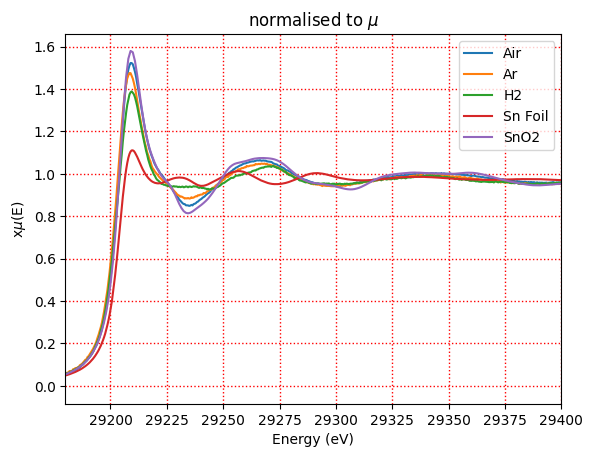

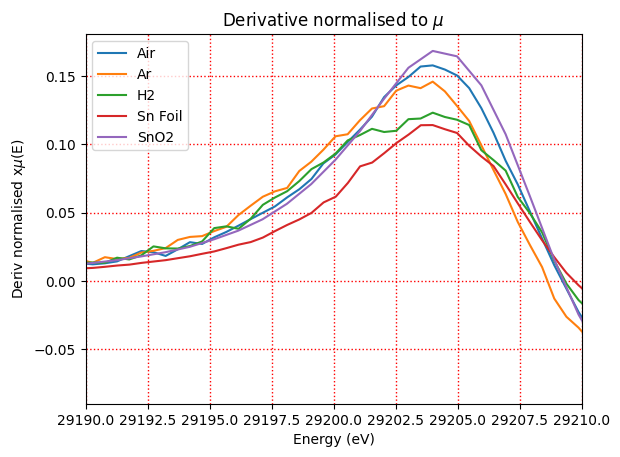

In [5]:
include_groups = ["Air", "Ar", "H2", "Sn Foil", "SnO2"]
for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_normalised(merged_results[a_sample])
    
plt.xlim([29180, 29400])
plt.show()

for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_derivative(merged_results[a_sample])
    
plt.xlim([29190, 29210])
plt.show()

### Linear combination fitting (LCF)
Lineal combination fitting with defaults for the H2, Ar and Air readings (Shown on Fig. 4 B)

In [6]:
# these functions are only used here to create the plot with three subplots for the paper
def make_subplot(a_subplt, group1, group2):
    a_subplt.plot(group1.energy, group1.norm, label=group1.filename, linewidth=4,color='blue')
    a_subplt.plot(group2.energy, group2.norm, label=group2.filename, linewidth=2, color='orange',linestyle='--')
    a_subplt.grid(color='black', linestyle=':', linewidth=1) #show and format grid
    a_subplt.set_title(group2.arrayname, fontsize=8)
    a_subplt.legend() # show legend
     
    a_subplt.set_xlim([29190, 29230])
    #a_subplt.set_ylim([0, 1.5])
    #a_subplt.tick_params(axis='both', which='major', labelsize=9)
    #xlabels = a_subplt.get_xticklabels()
    #a_subplt.set_xticks(xlabels, rotation = 90)
    return a_subplt

def make_main_plot(lcf_1, lcf_2, lcf_3):
    fig, axes = plt.subplots(1,3, constrained_layout=True)
    axes[0] = make_subplot(axes[0], lcf_1[0], lcf_1[1])
    axes[1] = make_subplot(axes[1], lcf_2[0], lcf_2[1])
    axes[2] = make_subplot(axes[2], lcf_3[0], lcf_3[1])
    return fig

In [7]:
lcf_components = [merged_results["Sn Foil"],merged_results["SnO2"]] # List of groups to use as components 
r_H2 = athenamgr.lcf_group(merged_results["H2"], lcf_components)
r_Ar = athenamgr.lcf_group(merged_results["Ar"], lcf_components)
r_Air = athenamgr.lcf_group(merged_results["Air"], lcf_components)

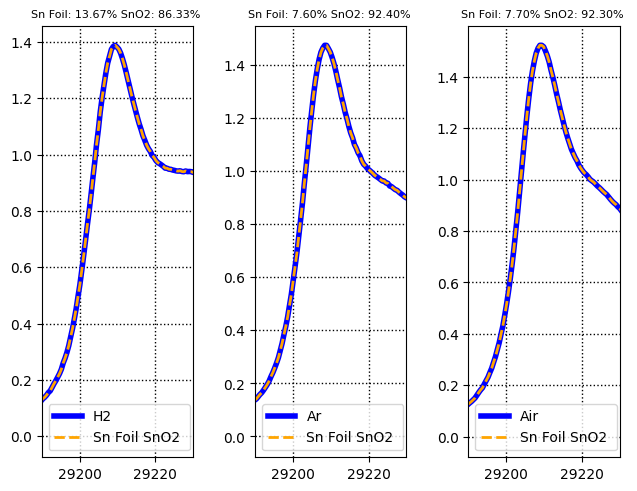

Sn Foil: 13.67% SnO2: 86.33% 


In [8]:
make_main_plot([merged_results["H2"],r_H2], [merged_results["Ar"],r_Ar], [merged_results["Air"],r_Air])
plt.show()

print(r_H2.arrayname)

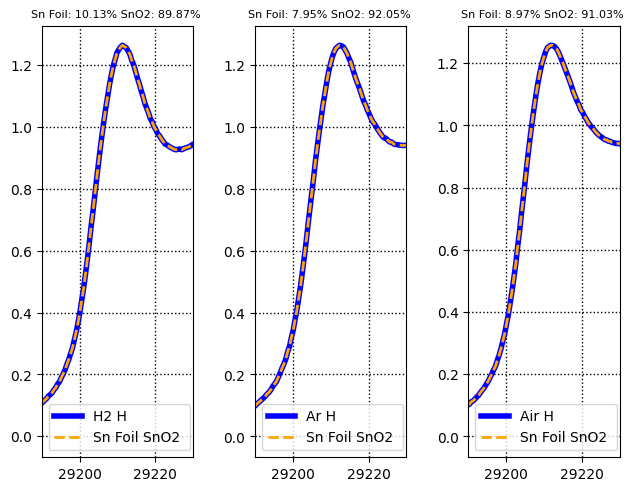

In [9]:
r_HH2 = athenamgr.lcf_group(merged_results["H2 H"], lcf_components)
r_HAr = athenamgr.lcf_group(merged_results["Ar H"], lcf_components)
r_HAir = athenamgr.lcf_group(merged_results["Air H"], lcf_components)

make_main_plot([merged_results["H2 H"],r_HH2], [merged_results["Ar H"],r_HAr], [merged_results["Air H"],r_HAir])
plt.show()

In [10]:
print("Goodness of LCF fits")
print ("LCF for H2:\t", "%.4f" % r_H2.rfactor)
print ("LCF for Ar:\t", "%.4f" % r_Ar.rfactor)
print ("LCF for Air:\t", "%.4f" % r_Air.rfactor)
print ("LCF for H\\H2:\t","%.4f" % r_HH2.rfactor)
print ("LCF for H\\Ar:\t","%.4f" % r_HAr.rfactor)
print ("LCF for H\\Air:\t","%.4f" % r_HAir.rfactor)


Goodness of LCF fits
LCF for H2:	 0.0007
LCF for Ar:	 0.0004
LCF for Air:	 0.0004
LCF for H\H2:	 0.0023
LCF for H\Ar:	 0.0028
LCF for H\Air:	 0.0026


## Reproduce Figure 5 XAS Processing
Rebin is required for XAS processing (see [Athena Manual](https://bruceravel.github.io/demeter/documents/Athena/process/rebin.html). So after the XANES analysis

In [11]:
# Rebin Ar, Air and H2 Samples 
rebin_labels = ["H2", "Ar", "Air"]
rebinned_groups = {}
rebinned_gr=None
for a_sample in merged_results:
    if a_sample in rebin_labels:
        rebinned_gr = athenamgr.rebin_group(merged_results[a_sample])
        rebinned_gr.arrayname = a_sample+" Rebbined"
        rebinned_groups[a_sample+" Rebbined"] = rebinned_gr
        print(len(rebinned_gr.energy),"to", len(merged_results["Ar"].energy))


378 to 2093
378 to 2093
378 to 2093


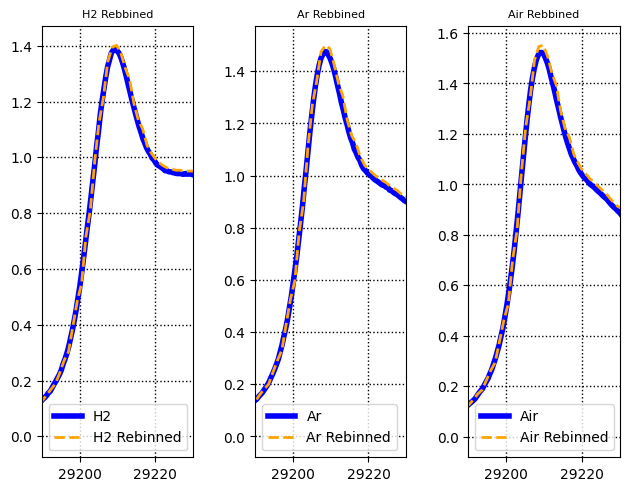

In [12]:
make_main_plot([merged_results["H2"],rebinned_groups["H2 Rebbined"]], 
               [merged_results["Ar"],rebinned_groups["Ar Rebbined"]], 
               [merged_results["Air"],rebinned_groups["Air Rebbined"]])
plt.show()

['H2', 'H2 Rebinned', 'Ar Rebinned', 'Air Rebinned']


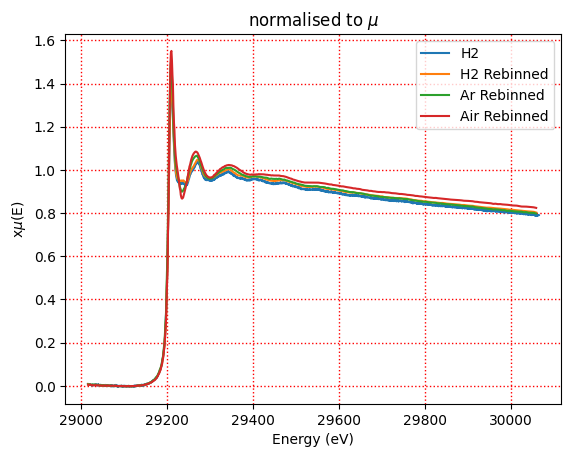

In [13]:
# read the input file 
athena_prj = athenamgr.read_project("merged.prj")

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
print(group_names)
for a_group in athena_groups:
    athenamgr.calc_with_defaults(a_group)
    plt = athenamgr.plot_normalised(a_group)
    plt.show

In [14]:
# Fitting input variables
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395.cif"] #Pt3Sn
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1690711.cif"] #SnO2
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395.cif",
                 "C:/harwell/PSDI_test/wf_data/pub_037/additional/1690711.cif"] #

gds_parms_f = "SnK_edge_gds.csv"
sel_paths_f = "SnK_edge_sp.csv"

show_graph = False # False to prevent showing graphs

# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=0 
fit_vars['kmax']=10
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=0.0
fit_vars['rmax']=5.0

# Need to specify the absorbing atom and maximum radius
absorbing_atoms = ["Pt","Sn"]
max_radius = 8.0

### Atoms and FEFF

Larch does larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.


In [15]:
# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files, absorbing_atoms, max_radius)

cif
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : comment: None given
 : Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1692395.cif
 : Structure Summary:  Sn1 Pt3
 : Reduced formula:  SnPt3
 : space group: (Pm-3m), space number:  (221)
 : abc:  3.967000   3.967000   3.967000
 : angles: 90.000000  90.000000  90.000000
 : sites: 4
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique 

 : 125     0.138    32.000     4   7.6637 neglected
 : 126     0.264    16.000     4   7.6637 neglected
 : 127     0.248    16.000     4   7.6637 neglected
 : 128     0.108    32.000     4   7.6637 neglected
 : 129     0.073    32.000     4   7.6637 neglected
 : 130     0.070    32.000     4   7.6637 neglected
 : 131     0.473    16.000     4   7.6637 neglected
 : 132     1.020    16.000     4   7.6637 neglected
 : 133     0.498    32.000     4   7.6637 neglected
 : 134     0.536    32.000     4   7.6637 neglected
 : 135     0.466    32.000     4   7.6637 neglected
 : 136     0.209    32.000     4   7.6637 neglected
 : 137     0.061    32.000     3   7.6749 neglected
 : 138     0.121    64.000     3   7.9184 neglected
 : 139     0.093    32.000     3   7.9184 neglected
 : 140     0.273    64.000     3   7.9184 neglected
 : 141     0.116    32.000     3   7.9184 neglected
 : 142     0.208    64.000     3   7.9184 neglected
 : 143     0.072    32.000     3   7.9184 neglected
 : 144     0

 : 100    13.921     8.000     2   5.7153
 : 101    13.288     8.000     3   5.7194
 : 102    12.307     8.000     3   5.7194
 : 103     0.329    16.000     4   5.7235 neglected
 : 104     6.365     4.000     4   5.7235
 : 105     0.979    16.000     4   5.7235 neglected
 : 106     5.545     4.000     4   5.7235
 : 107     0.829    16.000     3   5.7279 neglected
 : 108     0.557    16.000     4   5.7354 neglected
 : 109     0.891    16.000     4   5.7354 neglected
 : 110     1.241     8.000     3   5.7414 neglected
 : 111     0.900     8.000     4   5.7414 neglected
 : 112     1.916     8.000     4   5.7414 neglected
 : 113     0.867    16.000     4   5.7428 neglected
 : 114     1.223     8.000     3   5.7597 neglected
 : 115     0.887     8.000     4   5.7597 neglected
 : 116     1.876     8.000     4   5.7597 neglected
 : 117     4.456     8.000     2   5.7908
 : 118     0.530     8.000     4   5.8055 neglected
 : 119     0.858     8.000     4   5.8055 neglected
 : 120     0.758    

In [16]:
from larch import Interpreter
session = Interpreter()
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_parms_f, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

No conda env active, defaulting to base


Sheet(cells=(Cell(column_start=0, row_end=16, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [28]:
#read the gds data and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

#### Show all FEFF paths

To select a path change the value of the select column to 1 in the table displayed after running the cell below.

In [18]:
path_sheet = fit_manager.show_feff_paths(crystal_files)#('FeS2.inp')
display(path_sheet)

Reading from 1692395_feff
1692395_feff path and 1692395_feff\files.dat found
Reading from: 1692395_feff\files.dat
1: comment: None given                                    Feff 6L.02  potph 4.12
2: Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1692395.cif
3: Structure Summary:  Sn1 Pt3
4: Reduced formula:  SnPt3
5: space group: (Pm-3m), space number:  (221)
6: abc:  3.967000   3.967000   3.967000
7: angles: 90.000000  90.000000  90.000000
8: sites: 4
9: Abs   Z=78 Rmt= 1.381 Rnm= 1.498 K shell
10: Pot 1 Z=78 Rmt= 1.390 Rnm= 1.516
11: Pot 2 Z=50 Rmt= 1.432 Rnm= 1.579
12: Gam_ch=4.565E+01 H-L exch
13: Mu=-4.413E+00 kf=1.942E+00 Vint=-1.878E+01 Rs_int= 1.867
Reading from 1690711_feff
1690711_feff path and 1690711_feff\files.dat found
Reading from: 1690711_feff\files.dat
1: comment: None given                                    Feff 6L.02  potph 4.12
2: Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1690711.cif
3: Structure Summary:  Sn2 O4
4: Reduced formula:  SnO2
5:

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=62, row_start=0, squeeze_column=False, squeeze_row=Fal…

#### 2.5.2 Assing parameters to paths

To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                  |label | s02 |e0   |sigma2 |deltar      |
|----------------------|------|-----|-----|-------|------------|
|FeS2_feff/feff0001.dat|S1    |amp  |enot |ss     |alpha\*reff |
|FeS2_feff/feff0002.dat|S2    |amp  |enot |ss2    |alpha\*reff |
|FeS2_feff/feff0003.dat|S3    |amp  |enot |ss3    |alpha\*reff |
|FeS2_feff/feff0004.dat|Fe    |amp  |enot |ssfe   |alpha\*reff |


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.


In [36]:
sp_sheet = fit_manager.show_selected_paths(path_sheet)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=6, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [39]:
fit_manager.save_selected_paths_list(sp_sheet, sel_paths_f)
selected_paths = fit_manager.read_selected_paths_list(sel_paths_f, session)

### 2.6 Run Fit

XAS fitting is performed in three steps:

1. Create a Transform group to hold the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.

In [40]:
# run fit
trans, dset, out = fit_manager.run_fit(athena_groups[1], gds, selected_paths, fit_vars, session)

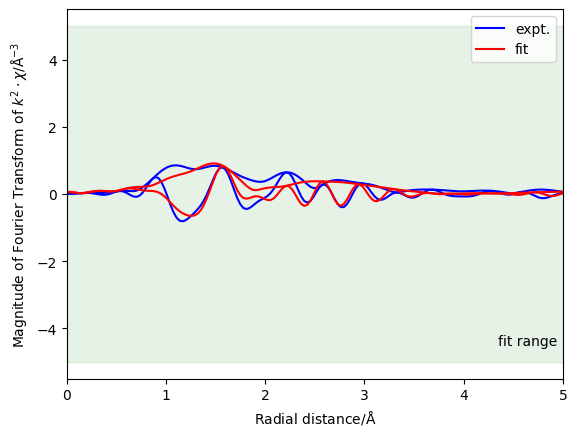

In [41]:
rmr_p = fit_manager.plot_rmr(dset,fit_vars['rmin'],fit_vars['rmax'])
rmr_p.show()

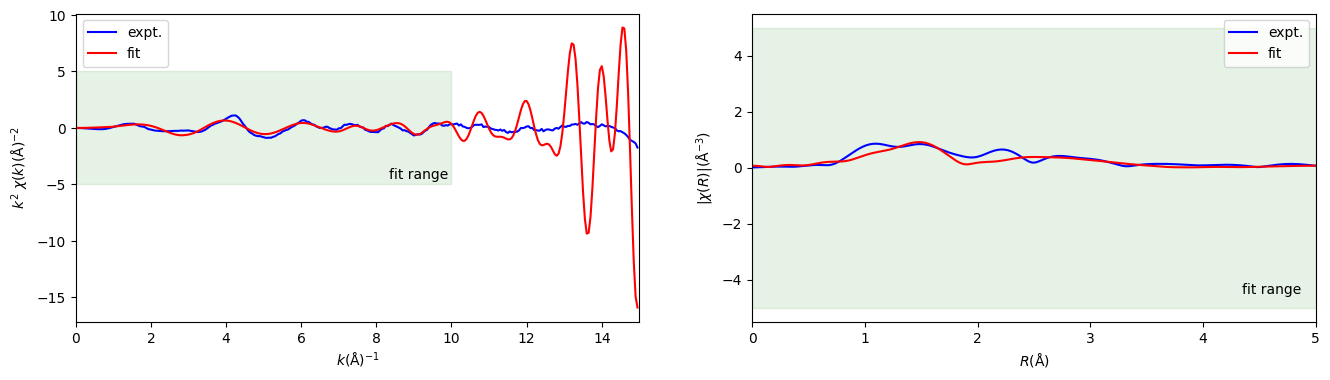

In [42]:
chikr_p = fit_manager.plot_chikr(dset,fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'])
chikr_p.show()

In [ ]:
merged_results["H2"]

In [ ]:
from larch.io import create_athena

def save_groups(xas_groups, out_file):
    #logging.info ("project path: "+ str(out_file))
    xas_project = create_athena(out_file)
    for xas_data in xas_groups:
        xas_project.add_group(xas_data)
    xas_project.save() 
    

save_groups([merged_results["H2"],rebinned_groups["H2 Rebbined"],rebinned_groups["Ar Rebbined"],rebinned_groups["Air Rebbined"]], "merged.prj")

#athena_prj = athenamgr.read_project("rebinned.prj")

#athena_groups = athenamgr.get_groups(athena_prj)

#for a_group in athena_groups:
#    athenamgr.calc_with_defaults(a_group)
    

In [ ]:
import re
lines = ["    99    3  32.000  index, nleg, degeneracy, r=  7.2674\n",
         "      x           y           z     ipot  label      rleg      beta        eta\n",
         "   -3.967000    3.967000    3.967000   1 'Pt    '     6.8710  144.7356    0.0000",
         "   -3.967000    1.983500    1.983500   1 'Pt    '     2.8051   54.7356    0.0000",
         "    0.000000    0.000000    0.000000   0 'Pt    '     4.8586  160.5288    0.0000",
         "   100    3  32.000  index, nleg, degeneracy, r=  7.2878",
         "      x           y           z     ipot  label      rleg      beta        eta",
         "   -1.983500    1.983500   -3.967000   2 'Sn    '     4.8586  120.0000    0.0000",
         "    1.983500    3.967000   -1.983500   1 'Pt    '     4.8586  120.0000    0.0000",
         "    0.000000    0.000000    0.000000   0 'Pt    '     4.8586  120.0000    0.0000",
         "   101    3  32.000  index, nleg, degeneracy, r=  7.2878",
         "      x           y           z     ipot  label      rleg      beta        eta",
         "   -1.983500    1.983500   -3.967000   2 'Sn    '     4.8586  120.0000    0.0000",
         "    1.983500    3.967000   -1.983500   1 'Pt    '     4.8586  120.0000    0.0000",
         "    0.000000    0.000000    0.000000   0 'Pt    '     4.8586  120.0000    0.0000",]
a_path = {}
count = 0
is_meta = False
for a_line in lines:
    count += 1
    if re.match('-{15}', a_line.strip())!= None:
        is_meta = False
        #print("{}: {}".format(count, a_line.strip()))
    elif not is_meta:
        if re.match("\s*\d*\s{4}\d*\s{3}", a_line) != None:
            if a_path != {}:
                all_paths[a_path['index']] = a_path
            line_data = a_line.split()
            a_path ={'index':line_data[0],'nleg':line_data[1],'degeneracy':line_data[2]}
        elif re.match("\s{6}x\s{11}y\s{5}", a_line) == None: # ignore the intermediate headings
            line_data = a_line.split()
            if not 'label' in a_path:
                a_path['label'] = line_data[4].replace("'","")
            else:
                a_path['label'] += '.'+line_data[4].replace("'","")
        

all_paths ={}        
for a_line in lines:
    count += 1
    if re.match('-{15}', a_line.strip())!= None:
        is_meta = False
        #print("{}: {}".format(count, a_line.strip()))
    elif not is_meta:
        line_data = a_line.split()
        if 'degeneracy,' in a_line.split():
            if a_path != {}:
                all_paths[a_path['index']] = a_path
            line_data = a_line.split()
            a_path ={'index':line_data[0],'nleg':line_data[1],'degeneracy':line_data[2]}
        elif re.match("\s{6}x\s{11}y\s{5}", a_line) == None: # ignore the intermediate headings
            line_data = a_line.split()
            if not 'label' in a_path:
                a_path['label'] = line_data[4].replace("'","")
            else:
                a_path['label'] += '.'+line_data[4].replace("'","")
        
print(all_paths)


In [ ]:
dir (merged_results["Ar Rebinned"])

In [ ]:
import random

print(random.randint(0, 3))

In [ ]:
len(merged_results["Ar Rebinned"].rebinned.delta_mu)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.02)

ax1 = plt.subplot(131)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(132)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(133)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()

In [ ]:
def example_plot(ax, fontsize=12, hide_labels=False):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    if hide_labels:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)

fig, ax = plt.subplots(layout=None)
example_plot(ax, fontsize=24)
fig, axs = plt.subplots(1, 3, layout="constrained")
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
                            wspace=0.2)

In [ ]:
fig, axes = plt.subplots(1,3, constrained_layout=True)

plt.show()

In [ ]:
import re

import ipysheet

def show_feff_paths2(f_paths = ["FeS2.inp"]):
    path_count = 0
    paths_data = []
    for var in f_paths:
        crystal_f = Path(var)
        feff_dir = crystal_f.name[:-4]+"_feff"
        feff_inp = crystal_f.name[:-4]+"_feff.inp"
        feff_files = "files.dat"
        print("Reading from", feff_dir)
        input_file = Path(feff_dir, feff_files)

        #check if feff dir exists
        if input_file.parent.exists() and input_file.exists():
            print(str(input_file.parent) + " path and "+ str(input_file)+ " found")
        else:
            print(str(input_file.parent) + " path not found, run feff before running select paths")
            return False
        count = 0
        # the .dat data is stored in fixed width strings 
        field_widths = [[0,13],[14,21],[22,31],[32,41],[42,48],[49,61]]
        is_meta = True
        data_headers = []
        #paths_data = []
        # get the list of paths info to assing labels to paths
        paths_info = fit_manager.get_path_labels(Path(feff_dir, 'paths.dat'))
        print("Reading from: "+ str(input_file))
        with open(input_file) as datfile:
            dat_lines = datfile.readlines()
            for a_line in dat_lines:
                count += 1
                if re.match('-*', a_line.strip()).group(0)!= '':
                    is_meta = False
                    print("{}: {}".format(count, a_line.strip()))
                elif is_meta:
                    print("{}: {}".format(count, a_line.strip()))
                elif data_headers == []:
                    data_headers = [a_line[s:e].strip().replace(' ','_') for s,e in field_widths]
                    print("headers:"+ str(data_headers))
                    data_headers.append('label')
                    data_headers.append('select')
                    paths_data.append(data_headers)
                else:
                    path_count += 1
                    data_values = [a_line[s:e].strip() for s,e in field_widths]
                    path_id = str(int(data_values[0][-8:-4]))
                    data_values.append(paths_info[path_id]['label']+'.'+path_id)                    
                    data_values.append(0)
                    data_values[0] = feff_dir+"/"+data_values[0]
                    paths_data.append(data_values)
        input()
    # use data to populate spreadsheet
    path_sheet = ipysheet.sheet(rows=len(paths_data), columns=8)
    ipysheet.cell_range(paths_data)
    print (paths_data)
    return path_sheet



In [ ]:
path_sheet = show_feff_paths2(crystal_files)#('FeS2.inp')
display(path_sheet)

In [ ]:
paths_data